In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import librosa as lb
import IPython.display as ipd
import librosa.display
import soundfile as sf
import os
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

### Defining functions

In [2]:
def extractID(filename):
    return filename.split('_')[0]
  
def customizeDataset(trim_size, data):
    count = 0
    placeholder = []
    for i in range(len(data)):
        a, b, c = data.iloc[i]
        if data.iloc[i].disease == 'COPD' and trim_size: 
            if count < trim_size:
                placeholder.append([a,b,c])
                count+=1
            continue
        if data.iloc[i].disease == 'Asthma' or data.iloc[i].disease == 'LRTI':
            continue
        placeholder.append([a,b,c])

    return pd.DataFrame(data=placeholder, columns=['pid', 'filename', 'disease'])

def getFeatures(input, feature):
    X_mfcc, X_cstft, X_mSpec = [], [], []
    for i in range(len(input)):
        soundArr, sample_rate = lb.load('/content/drive/MyDrive/Respiration_Classification/processed_audio_files/' + input.iloc[i].filename)
        if feature == 'mfcc':
          mfcc = lb.feature.mfcc(soundArr, sr=sample_rate, n_mfcc=40).flatten()
          X_mfcc.append(mfcc)
        elif feature == 'cstft':
          X_cstft.append(lb.feature.chroma_stft(y=soundArr,sr=sample_rate))
        elif feature == 'mspec':
          X_mSpec.append(lb.feature.melspectrogram(y=soundArr,sr=sample_rate))
    return X_mfcc, X_cstft, X_mSpec

def plotConfusionMatrix(cf):
    #disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI'])
    return disp.plot(xticks_rotation='vertical')

### Generation of dataset

In [3]:
length = len(os.listdir('/content/drive/MyDrive/Respiration_Classification/processed_audio_files/'))
index = range(length)

# We will now create a new dataframe with the class corresponding to the pid for each of the processed_audio_files.
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])

for f in os.listdir('/content/drive/MyDrive/Respiration_Classification/processed_audio_files/'):
    files_df.iloc[i]['pid'] = extractID(f)
    files_df.iloc[i]['filename'] = f
    i+=1

files_df.head()

diagnosis=pd.read_csv('/content/drive/MyDrive/Respiration_Classification/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

files_df.pid=files_df.pid.astype('int64') # both pid's must be of same dtype for them to merge
data=pd.merge(files_df,diagnosis,on='pid')

# Down-sampling by cutting a big chunk of COPD samples
new_dataset = customizeDataset(600, data)

In [4]:
from sklearn.model_selection import train_test_split

# Now we have the training and test set.
X_train, X_test, y_train, y_test = train_test_split(new_dataset, new_dataset.disease, stratify=new_dataset.disease, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, X_train.disease, stratify=X_train.disease, test_size=0.25, random_state=42)
X_train.to_csv('/content/drive/MyDrive/Respiration_Classification/train.csv')
X_test.to_csv('/content/drive/MyDrive/Respiration_Classification/test.csv')
X_val.to_csv('/content/drive/MyDrive/Respiration_Classification/validation.csv')

train = pd.read_csv('/content/drive/MyDrive/Respiration_Classification/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Respiration_Classification/test.csv')
validation = pd.read_csv('/content/drive/MyDrive/Respiration_Classification/validation.csv')

y_train = train.disease
y_test = test.disease
y_val = validation.disease

### Feature extraction and Cepstral Mean and Variance Normalization (CMVN)

In [5]:
X_test_mfcc , X_test_cstft, X_test_mspec = getFeatures(X_test, 'mfcc')
X_train_mfcc, X_train_cstft, X_train_mspec = getFeatures(X_train, 'mfcc')
X_val_mfcc, X_val_cstft, X_val_mspec = getFeatures(X_val, 'mfcc')

mean = np.mean(X_train_mfcc, axis=0)
std = np.std(X_train_mfcc, axis=0)

X_train_mfcc = (X_train_mfcc - mean)/std
X_test_mfcc = (X_test_mfcc - mean)/std
X_val_mfcc = (X_val_mfcc - mean)/std

X_test_mfcc = np.array(X_test_mfcc)
X_train_mfcc = np.array(X_train_mfcc)
X_val_mfcc = np.array(X_val_mfcc)

### Handling imbalance - SMOTE Approach

In [6]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_mfcc_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train_mfcc, y_train)

### Indexing the labels

In [7]:
y_train_SMOTE = pd.DataFrame(y_train_SMOTE)
y_train_SMOTE = y_train_SMOTE.replace('Healthy', 1)
y_train_SMOTE = y_train_SMOTE.replace('URTI', 2)
y_train_SMOTE = y_train_SMOTE.replace('COPD', 3)
y_train_SMOTE = y_train_SMOTE.replace('Bronchiectasis', 4)
y_train_SMOTE = y_train_SMOTE.replace('Pneumonia', 5)
y_train_SMOTE = y_train_SMOTE.replace('Bronchiolitis', 6)
y_train_SMOTE = y_train_SMOTE.replace(np.nan, '0')
y_train_SMOTE = np.ravel(y_train_SMOTE)

y_val = pd.DataFrame(y_val)
y_val = y_val.replace('Healthy', 1)
y_val = y_val.replace('URTI', 2)
y_val = y_val.replace('COPD', 3)
y_val = y_val.replace('Bronchiectasis', 4)
y_val = y_val.replace('Pneumonia', 5)
y_val = y_val.replace('Bronchiolitis', 6)
y_val = y_val.replace(np.nan, '0')
y_val = np.ravel(y_val)

y_test = pd.DataFrame(y_test)
y_test = y_test.replace('Healthy', 1)
y_test = y_test.replace('URTI', 2)
y_test = y_test.replace('COPD', 3)
y_test = y_test.replace('Bronchiectasis', 4)
y_test = y_test.replace('Pneumonia', 5)
y_test = y_test.replace('Bronchiolitis', 6)
y_test = y_test.replace(np.nan, '0')
y_test = np.ravel(y_test)

### Random Forest Classifier

Accuracy of training at depth 1 :  0.4675925925925926
Accuracy of validation at depth 1 :  0.4518950437317784
Accuracy of training at depth 3 :  0.6032407407407407
Accuracy of validation at depth 3 :  0.5568513119533528
Accuracy of training at depth 5 :  0.8430555555555556
Accuracy of validation at depth 5 :  0.6822157434402333
Accuracy of training at depth 7 :  0.9472222222222222
Accuracy of validation at depth 7 :  0.7376093294460642
Accuracy of training at depth 9 :  0.9861111111111112
Accuracy of validation at depth 9 :  0.7551020408163265
Accuracy of training at depth 11 :  0.9990740740740741
Accuracy of validation at depth 11 :  0.7696793002915452
Accuracy of training at depth 13 :  1.0
Accuracy of validation at depth 13 :  0.7725947521865889
Accuracy of training at depth 15 :  1.0
Accuracy of validation at depth 15 :  0.7959183673469388
Accuracy of training at depth 17 :  1.0
Accuracy of validation at depth 17 :  0.7900874635568513
Accuracy of training at depth 19 :  1.0
Accurac

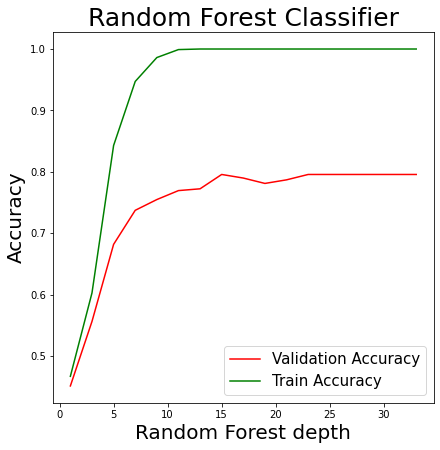

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

max_estimators = range(1, 34, 2)
test_errors = []
train_errors = []
accuracy_val = []
accuracy_train = []
val_pred = 0

for i in max_estimators:
    rf = RandomForestClassifier(random_state = 100, max_depth = int(i))# Train the model on training data
    rf.fit(X_train_mfcc_SMOTE, y_train_SMOTE);

    train_pred = rf.predict(X_train_mfcc_SMOTE)
    acccuracy_scores = accuracy_score(y_train_SMOTE, train_pred)
    print("Accuracy of training at depth", i, ": ", acccuracy_scores)
    accuracy_train = np.append(accuracy_train, acccuracy_scores)

    val_pred = rf.predict(X_val_mfcc)
    acccuracy_scores = accuracy_score(y_val, val_pred)
    print("Accuracy of validation at depth", i, ": ", acccuracy_scores)
    accuracy_val = np.append(accuracy_val, acccuracy_scores)

#cf = confusion_matrix(y_val, val_pred)
#plotConfusionMatrix(cf)

plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(221)
line1, = plt.plot(max_estimators, accuracy_val, 'r', label="Validation Accuracy")
line3, = plt.plot(max_estimators, accuracy_train, 'g', label="Train Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy', size = 20)
plt.xlabel('Random Forest depth', size = 20)
plt.legend(prop={'size': 15})
plt.title('Random Forest Classifier', size = 25)
plt.show()

### Decision Tree Classifier

Accuracy 0.5714285714285714


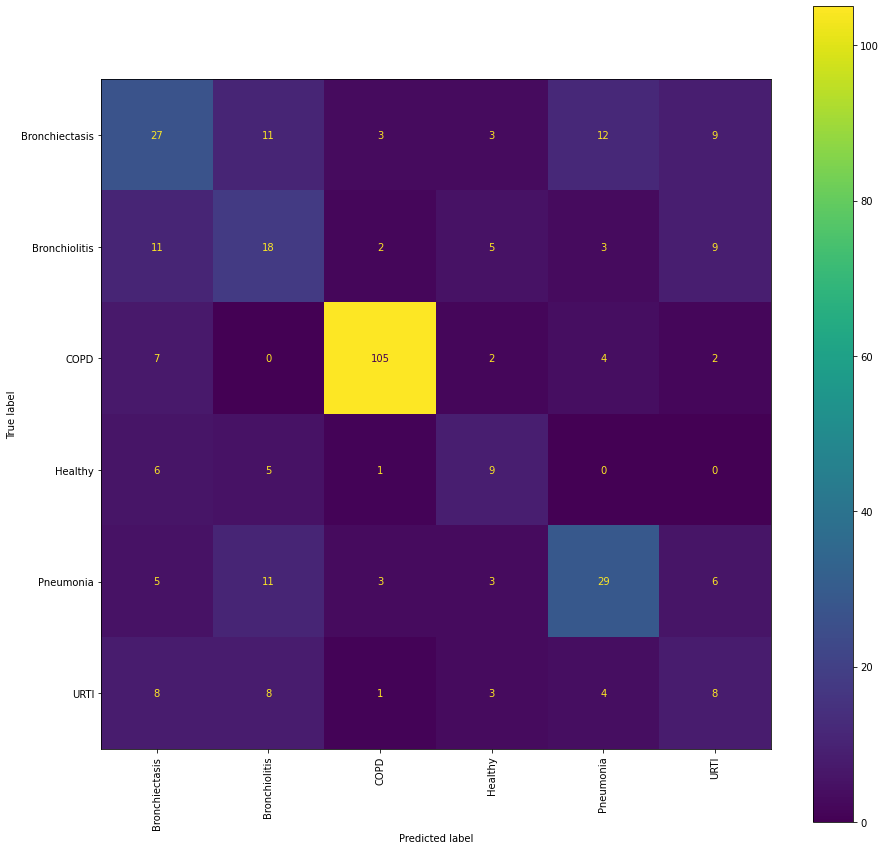

In [12]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion="gini", max_depth=100, random_state=42)
clf = clf.fit(X_train_mfcc_SMOTE, y_train_SMOTE)
y_pred = clf.predict(X_val_mfcc)
print("Accuracy", accuracy_score(y_val, y_pred))
cf = confusion_matrix(y_val, y_pred)
plotConfusionMatrix(cf)

### SVM Classifier

In [52]:
from sklearn.svm import SVC
SVM = SVC(probability=True, kernel="linear", class_weight="balanced")
SVM.fit(X_train_mfcc_SMOTE, y_train_SMOTE)
y_pred = SVM.predict(X_val_mfcc)
cf = confusion_matrix(y_val, y_pred)
acccuracy_scores = accuracy_score(y_val, y_pred)
print("Accuracy of test at depth: ", acccuracy_scores)

Accuracy of test at depth:  0.7784256559766763


### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=42, max_iter=700)
LR.fit(X_train_mfcc_SMOTE, y_train_SMOTE)
y_pred = LR.predict(X_val_mfcc)
cf = confusion_matrix(y_val, y_pred)
acccuracy_scores = accuracy_score(y_val, y_pred)
print("Accuracy of test at depth: ", acccuracy_scores)

Accuracy of test at depth:  0.7580174927113703


### K-NN Classifier

Accuracy of test at neighbour  1 :  0.7959183673469388
Accuracy of test at neighbour  3 :  0.7959183673469388
Accuracy of test at neighbour  5 :  0.7959183673469388
Accuracy of test at neighbour  7 :  0.7959183673469388
Accuracy of test at neighbour  9 :  0.7959183673469388
Accuracy of test at neighbour  11 :  0.7959183673469388
Accuracy of test at neighbour  13 :  0.7959183673469388
Accuracy of test at neighbour  15 :  0.7959183673469388
Accuracy of test at neighbour  17 :  0.7959183673469388
Accuracy of test at neighbour  19 :  0.7959183673469388


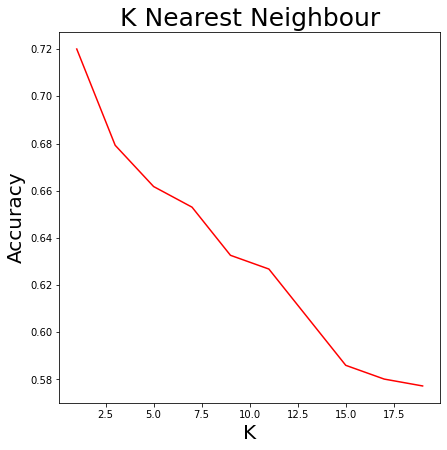

In [9]:
from sklearn.neighbors import KNeighborsClassifier
max_neighbours = range(1, 21, 2)
accuracy_val = []
accuracy_scores = []
for i in max_neighbours:
  nearest_neighbour = KNeighborsClassifier(n_neighbors=i)
  nearest_neighbour.fit(X_train_mfcc_SMOTE, y_train_SMOTE)
  y_pred = nearest_neighbour.predict(X_val_mfcc)
  accuracy_scores = accuracy_score(y_val, y_pred)
  accuracy_val = np.append(accuracy_val, accuracy_scores)
  print("Accuracy of test at neighbour ", i, ": ", acccuracy_scores)

plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(221)
plt.plot(max_neighbours, accuracy_val, 'r', label="Validation Accuracy")
plt.ylabel('Accuracy', size = 20)
plt.xlabel('K', size = 20)
plt.title('K Nearest Neighbour', size = 25)
plt.show()

In [113]:
accuracy_val

array([0.72727273, 0.68319559, 0.66115702, 0.63360882, 0.63360882,
       0.61157025, 0.59504132, 0.58677686, 0.58677686, 0.57300275])

### Voting Classifier

0.8264462809917356


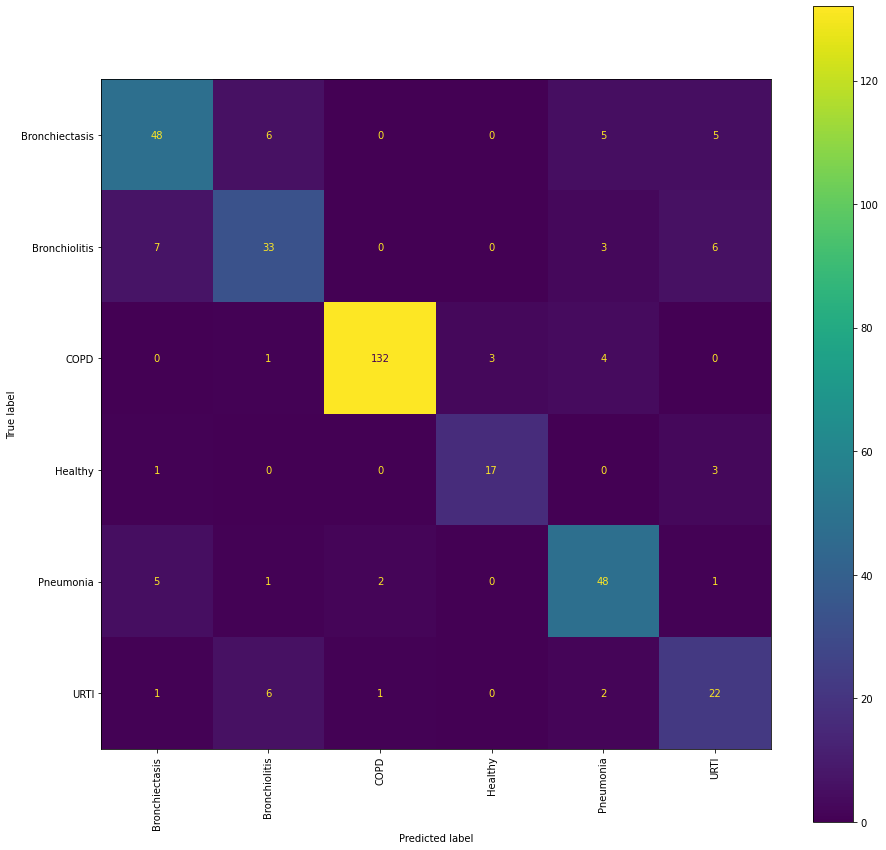

In [114]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

RF = RandomForestClassifier(random_state = 100, max_depth = 27)
SVM = SVC(probability=True, kernel='linear')
nearest_neighbour = KNeighborsClassifier(n_neighbors=3)
LR = LogisticRegression(random_state=42, max_iter=700)

estimators=[('svm', SVM), ('rf', RF), ('nn', nearest_neighbour)]
VC = VotingClassifier(estimators=estimators, voting='soft')
VC.fit(X_train_mfcc_SMOTE, y_train_SMOTE)
y_pred = VC.predict(X_test_mfcc)
cf = confusion_matrix(y_test, y_pred)
print(accuracy_score(y_test, y_pred))
plotConfusionMatrix(cf)